In [ ]:
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import ipywidgets as widgets
import pandas as pd
import io

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import InputLayer, Flatten, Dense

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path direktori hasil ekstraksi
data_dir = '/content/drive/MyDrive/Capstone_Project/Dataset/Minuman'

# Tampilkan daftar folder di direktori dataset
print("Files in directory:", os.listdir(data_dir))

# Hitung jumlah kategori (subfolder)
print("Number of categories (folders):", len(os.listdir(data_dir)))

#jumlah produk diambil dari total folder
num_classes = len(os.listdir(data_dir))

#Penyesuaian ukuran gambar
image_size = 120

Files in directory: ['Cimory Susu Coklat rasa cashew 250 ml', 'Tehbotol sosro 250ml', 'Mizone 500ml', 'ABC Kopi Susu', 'Ichitan Thai Green Tea', 'BearBrand', 'Yakult', 'Cimory bebas laktosa 250ml', 'Ultramilk Fullcream 250ml', 'Ultra milk coklat Ultrajaya 200ml', 'Teh Pucuk Harum', 'Fruit Tea Freeze 350ml', 'Cola-Cola 390ml', 'Fanta Rasa Stroberi 390ml', 'Sprite 390ml', 'Floridina', 'NU Green Tea Yogurt', 'Larutan Penyegar Rasa Jambu', 'Cimory Yogurt Strawberry 250ml', 'Benecol rasa lyche botol 100 ml', 'Pocari Sweat 500 ml', 'Nutriboost Orange Flavour 250ml', 'Hydro Coco Original 250 ml', 'TEBS Sparkling 330ml', 'You c 1000 orange', 'pepsi blue 330 ml', 'Teh kotak 200 ml']
Number of categories (folders): 27


In [ ]:
#Fungsi untuk augmentasi model
def create_augmentation_model():
    """Creates a model (layers stacked on top of each other) for augmenting images.

    Returns:
        tf.keras.Model: The model made up of the layers that will be used to augment the images.
    """
    augmentation_model = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.2),  # Rotasi acak
        tf.keras.layers.RandomZoom(0.2),     # Zoom acak
        tf.keras.layers.RandomFlip("horizontal"),  # Flip horizontal
        tf.keras.layers.RandomTranslation(0.2, 0.2)  # Translasi acak pada X dan Y
    ])
    return augmentation_model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Sequential

#Fungsi untuk membuat model
def create_classification_model(image_size, num_classes):
    """Creates a CNN model """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),

        Dense(64, activation='relu'),
        Dropout(0.5),

        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
def preprocess_image(file_path, image_size):
    """
    Fungsi untuk memproses gambar: memuat gambar, mengubah ukurannya, dan menormalkan.
    Args:
        file_path (str): Path file gambar
    Returns:
        tf.Tensor: Gambar yang sudah diproses
    """
    # Membaca gambar
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Mengkodekan gambar dalam format RGB

    # Mengubah ukuran gambar sesuai ukuran gambar yang ditentukan di image_size
    image = tf.image.resize(image, [image_size, image_size])

    # Normalisasi gambar (opsional, bisa disesuaikan)
    image = image / 255.0  # Mengubah nilai pixel menjadi antara 0 dan 1

    return image


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_data_generators(data_dir, image_size):
    """Creates ImageDataGenerators for training and validation with augmentation for a simple CNN."""
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalisasi sederhana
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        validation_split=0.2  # Membagi data menjadi pelatihan dan validasi dengan perbandingan 1/5
    )

    # Generator untuk set pelatihan
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',
        subset='training'  # Menggunakan subset training
    )

    # Generator untuk set validasi (tanpa augmentasi tambahan)
    val_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',
        subset='validation'  # Menggunakan subset validation
    )

    return train_generator, val_generator

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def train_model(model, train_generator, val_generator, epochs=100, patience=5, save_path='best_model.keras'): # Changed the file extension to .keras
    """
    Melatih model menggunakan data pelatihan dan validasi dengan callbacks untuk early stopping dan model checkpoint.

    Parameters:
    - model: Model yang akan dilatih.
    - train_generator: Generator untuk data pelatihan.
    - val_generator: Generator untuk data validasi.
    - epochs: Jumlah maksimum epoch untuk pelatihan.
    - patience: Jumlah epoch tanpa perbaikan sebelum menghentikan pelatihan (early stopping).
    - save_path: Path untuk menyimpan model terbaik berdasarkan performa pada set validasi.

    Returns:
    - history: Riwayat pelatihan model.
    """
    # Compile model
    Optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=Optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Callback untuk menghentikan pelatihan lebih awal jika tidak ada perbaikan pada set validasi
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Callback untuk menyimpan model terbaik selama pelatihan
    model_checkpoint = ModelCheckpoint(save_path, monitor='val_loss', save_best_only=True)

    # Melatih model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stopping, model_checkpoint]
    )

    return history

In [ ]:
# Membuat model augmentasi
augmentation_model = create_augmentation_model()

# Membuat model klasifikasi dengan transfer learning
classification_model = create_classification_model(image_size, num_classes)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


True


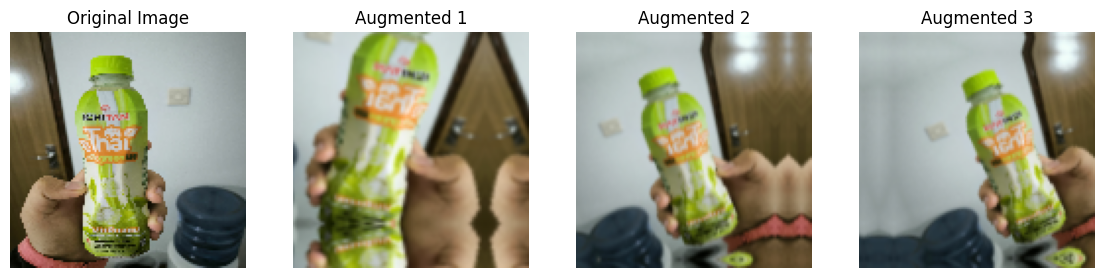

In [ ]:
path = "/content/drive/MyDrive/Capstone_Project/Dataset/Minuman/Ichitan Thai Green Tea/ICHI1 (1).jpg"
print(os.path.exists(path))
dataset = tf.data.Dataset.list_files(path)


dataset = dataset.map(lambda x: preprocess_image(x, image_size))  # Fungsi untuk memproses gambar
dataset = dataset.batch(32)  # Mengambil batch berisi 32 gambar

# Ambil batch pertama
example_batch_images = next(iter(dataset))
sample_image = tf.keras.utils.array_to_img(example_batch_images[0])

# Terapkan augmentasi acak 3 kali
images = [sample_image]

for _ in range(3):
    # Tambahkan dimensi batch (misalnya, batch size 1)
    image_with_batch = tf.expand_dims(sample_image, axis=0)

    # Augmentasi gambar
    image_aug = augmentation_model(image_with_batch)
    image_aug = tf.image.resize(image_aug, [image_size, image_size])  # Resize augmented images
    image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
    images.append(image_aug)


# Menampilkan gambar
fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3']):
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')

plt.show()


In [ ]:
#melakukan training model
train_generator, val_generator = create_data_generators(data_dir, image_size)
history = train_model(classification_model, train_generator, val_generator, epochs=500, patience=20, save_path='best_model.keras')

Found 1066 images belonging to 27 classes.
Found 263 images belonging to 27 classes.
Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0340 - loss: 3.2993

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 400s 10s/step - accuracy: 0.0339 - loss: 3.2993 - val_accuracy: 0.0342 - val_loss: 3.2895
Epoch 2/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.0396 - loss: 3.2915 - val_accuracy: 0.0760 - val_loss: 3.2875
Epoch 3/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.0385 - loss: 3.2984 - val_accuracy: 0.0760 - val_loss: 3.2878
Epoch 4/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.0452 - loss: 3.2923 - val_accuracy: 0.0760 - val_loss: 3.2841
Epoch 5/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.0809 - loss: 3.2800 - val_accuracy: 0.0760 - val_loss: 3.2728
Epoch 6/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.0519 - loss: 3.2839 - val_accuracy: 0.0760 - val_loss: 3.2736
Epoch 7/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.0579 - loss: 3.2735 - val_accuracy: 0.0760 - val_loss: 3.2603
Epoch 8/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.0603 - loss: 3.2671 - val_accuracy: 0.0837 - val_loss: 

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


In [ ]:
from io import BytesIO
from IPython.display import display, HTML


# Pastikan model Anda sudah diload sebelumnya
model = classification_model  # Menggunakan model klasifikasi yang dibuat sebelumnya

# Widget untuk meng-upload gambar
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)

out = widgets.Output()
display(out)

# Load file CSV
df_nutrition = pd.read_csv('/content/drive/MyDrive/Capstone_Project/Dataset/Minuman.csv')

def preprocess_and_augment(file):
    """
    Fungsi untuk memuat, memproses, dan augmentasi gambar.
    Args:
        file (str): Nama file gambar
    Returns:
        np.array: Gambar yang telah diproses dan diaugmentasi
    """
    # Memuat dan mengubah ukuran gambar
    img = tf.keras.utils.load_img(file, target_size=(image_size, image_size))
    img_array = tf.keras.utils.img_to_array(img) / 255.0  # Normalisasi nilai antara 0 dan 1

    # Augmentasi gambar menggunakan augmentation_model
    img_array = tf.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch
    augmented_img = augmentation_model(img_array)
    return tf.squeeze(augmented_img).numpy()  # Menghapus dimensi batch yang tidak diperlukan

def file_predict(filename, file, out):
    """ Fungsi untuk membuat prediksi, mencetak hasil output, dan menampilkan gambar yang di-upload """
    # Memuat dan mengubah ukuran gambar asli tanpa augmentasi untuk ditampilkan
    original_img = tf.keras.utils.load_img(file, target_size=(image_size, image_size))
    original_img_array = tf.keras.utils.img_to_array(original_img) / 255.0  # Normalisasi nilai antara 0 dan 1

    # Proses dan augmentasi gambar untuk prediksi
    img_array = preprocess_and_augment(file)
    img_array = np.expand_dims(img_array, axis=0)  # Membuat dimensi batch untuk prediksi

    # Prediksi gambar
    prediction = model.predict(img_array, verbose=0)

    # Menentukan kategori berdasarkan output model
    pred_class = np.argmax(prediction, axis=1)[0]
    label_map = {
        0: 'ABC Kopi Susu',
        1: 'BearBrand',
        2: 'Benechol rasa lychee botol 100 ml',
        3: 'Cimory Susu Coklat rasa cashew 250 ml',
        4: 'Cimory Yogurt Strawberry 250ml',
        5: 'Cimory bebas laktosa 250ml',
        6: 'Cola-Cola 390ml',
        7: 'Fanta Rasa Stroberi 390ml',
        8: 'Floridina',
        9: 'Fruit Tea Freeze 350ml',
        10: 'Hydro Coco Original 250 ml',
        11: 'Ichitan Thai Green Tea',
        12: 'Larutan Penyegar Rasa Jambu',
        13: 'Mizone 500ml',
        14: 'NU Green Tea Yogurt',
        15: 'Nutriboost Orange Flavour 250ml',
        16: 'Pocari Sweat 500 ml',
        17: 'Sprite 390ml',
        18: 'TEBS Sparkling 330ml',
        19: 'Teh Pucuk Harum',
        20: 'Teh kotak 200 ml',
        21: 'Tehbotol sosro 250ml',
        22: 'Ultra milk coklat Ultrajaya 200ml',
        23: 'Ultramilk Fullcream 250ml',
        24: 'Yakult',
        25: 'You c 1000 orange',
        26: 'pepsi blue 330 ml'
    }



    category = label_map[pred_class]

    with out:
        # Menampilkan gambar asli yang di-upload (tanpa augmentasi)
        plt.imshow(tf.keras.utils.array_to_img(original_img_array))
        plt.axis('off')
        plt.title(f"Uploaded Image (Original): {filename}")
        plt.show()

        # Menampilkan hasil prediksi kategori
        print(f"Gambar '{filename}' termasuk dalam kategori: {category} ", end="\n\n")

        # Mencari data nutrisi dari file CSV berdasarkan kategori
        nutrition_info = df_nutrition[df_nutrition['Nama Produk'] == category]

        if not nutrition_info.empty:
            # Menampilkan data nutrisi sebagai tabel HTML
            print("Informasi Gizi:")
            display(HTML(nutrition_info.to_html(index=False)))
        else:
            print("<i>Data nutrisi tidak ditemukan untuk kategori ini.</i>", end="\n\n")

def on_upload_change(change):
    """ Fungsi untuk mengambil file dari widget dan menjalankan prediksi """
    # Mendapatkan file yang diupload
    for name, data in change.new.items():
        file_jpgdata = BytesIO(data['content'])  # Access content from the data dictionary
        file_predict(name, file_jpgdata, out)

# Mengamati perubahan pada widget upload
uploader.observe(on_upload_change, names='value')

In [ ]:
df_nutrition